In [2]:
from typing import Dict, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joypy
import sys

from develop.utils.paths import DATA_ALT, NOTEBOOKS_ANALYSIS

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)

In [3]:
df_fixed = pd.read_csv(os.path.join(NOTEBOOKS_ANALYSIS, "fixed_base_with_z_score.csv"))
df_chain = pd.read_csv(os.path.join(NOTEBOOKS_ANALYSIS, "chain_base_with_z_score.csv"))

## Data preparation
Converting z-scores in acceptable bins:
| Z-Score Range        | Returned State | Description       |
|----------------------|----------------|-------------------|
| `NaN`                | 2              | Neutral state     |
| `z <= -4`            | 0              | Extreme low       |
| `-4 < z <= -1`       | 1              | Moderate low      |
| `z == 0`             | 2              | Neutral           |
| `1 <= z <= 3`        | 3              | Moderate high     |
| `z >= 4`             | 4              | Extreme high      |


In [75]:
def zscore_to_state(z):
    if pd.isna(z):
        return 2  # neutral state
    z = int(round(z))
    if z <= -4:
        return 0
    elif z <= -1:
        return 1
    elif z == 0:
        return 2
    elif z <= 3:
        return 3
    else:
        return 4  # z >= 4

def clip_and_prepare_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.drop(columns="Unnamed: 0", errors="ignore", inplace=True)

    # Clip and round raw z-scores
    df['z_score_kl_clipped'] = df['z_score_kl'].round().clip(lower=-6, upper=6)
    df['z_score_cosine_clipped'] = df['z_score_cosine'].round().clip(lower=-6, upper=6)

    # Fill NaNs (neutral middle bucket)
    df['z_score_kl_clipped_no_nans'] = df['z_score_kl_clipped'].fillna(0)
    df['z_score_cosine_clipped_no_nans'] = df['z_score_cosine_clipped'].fillna(0)

    # Map to 5 discrete HMM states (0 to 4)
    df['hmm_state'] = df['z_score_kl_clipped'].apply(zscore_to_state)
    df['hmm_state_cos'] = df['z_score_cosine_clipped'].apply(zscore_to_state)

    return df


In [76]:
df_chain = clip_and_prepare_df(df_chain)
df_fixed = clip_and_prepare_df(df_fixed)

In [77]:
df_chain.head()

,word,count,count_t-1,year,ref_year,euclidean_distance,cosine_similarity,cross_entropy,kl_divergence,entropy,entropy_t-1,mean,median,std,iqr,range,word_present_both,freq_pct_inc,freq_pct_inc_abs,z_score_kl,z_score_cosine,z_score_kl_max,z_score_kl_min,z_score_cosine_max,z_score_cosine_min,z_score_kl_clipped,z_score_cosine_clipped,z_score_kl_clipped_no_nans,z_score_cosine_clipped_no_nans,hmm_state,hmm_state_cos
0,new,25314,19851.0,1921,1920,6.4994,0.9206,65.9409,1.1245,64.8165,64.5339,0.5083,0.5141,0.1530,0.1734,0.8402,True,0.2752,0.2752,-0.0013,0.0061,6.0744,-6.8252,3.7503,-5.0970,-0.0,0.0,-0.0,0.0,2,2
1,today,16924,11878.0,1921,1920,7.2395,0.9138,67.0485,1.1286,65.9199,65.1703,0.5155,0.5166,0.1386,0.2055,0.7318,True,0.4248,0.4248,-0.0091,0.0505,3.4072,-4.4005,3.8323,-3.0554,-0.0,0.0,-0.0,0.0,2,2
2,yesterday,16662,12618.0,1921,1920,8.8012,0.9200,64.4156,2.1746,62.2410,61.6637,0.5185,0.5164,0.1842,0.2515,0.9272,True,0.3205,0.3205,0.0017,0.0910,5.1954,-4.2299,3.7874,-2.2285,0.0,0.0,0.0,0.0,2,2
3,say,12984,10863.0,1921,1920,7.1263,0.8950,67.0344,1.2862,65.7481,65.6699,0.5025,0.5061,0.1414,0.1461,0.7708,True,0.1952,0.1952,-0.0018,0.0016,5.8410,-7.1164,4.0078,-3.3277,-0.0,0.0,-0.0,0.0,2,2
4,state,12696,10885.0,1921,1920,8.8152,0.9076,69.5889,5.8680,63.7209,63.4445,0.4883,0.4867,0.1720,0.3037,0.7015,True,0.1664,0.1664,-0.0014,-0.0001,6.3467,-6.2380,3.6255,-3.4974,-0.0,-0.0,-0.0,-0.0,2,2


## Data Visualization - Single Word

In [78]:
def plot_KL_vs_COS(df: pd.DataFrame, word: str) -> None:
    dfw = df[df.word == word]

    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # === KL Divergence with dual axis ===
    ax1 = axs[0]
    ax2 = ax1.twinx()
    ax1.plot(dfw['year'], dfw['kl_divergence'], label='KL Divergence', color='blue')
    ax2.plot(dfw['year'], dfw['z_score_kl_clipped_no_nans'], label='Z-Score KL (Clipped)', color='orange')

    ax1.set_ylabel('KL Divergence', color='blue')
    ax2.set_ylabel('Z-Score KL', color='orange')

    ax1.set_title(f"KL Divergence and Z-Score over Time - word: {word}")
    ax1.grid(True)

    # === Cosine Similarity with dual axis ===
    ax3 = axs[1]
    ax4 = ax3.twinx()
    ax3.plot(dfw['year'], dfw['cosine_similarity'], label='Cosine Similarity', color='green')
    ax4.plot(dfw['year'], dfw['z_score_cosine_clipped_no_nans'], label='Z-Score Cosine (Clipped)', color='red')

    ax3.set_ylabel('Cosine Similarity', color='green')
    ax4.set_ylabel('Z-Score Cosine', color='red')

    ax3.set_title(f"Cosine Similarity and Z-Score over Time - word: {word}")
    ax3.set_xlabel('Year')
    ax3.grid(True)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


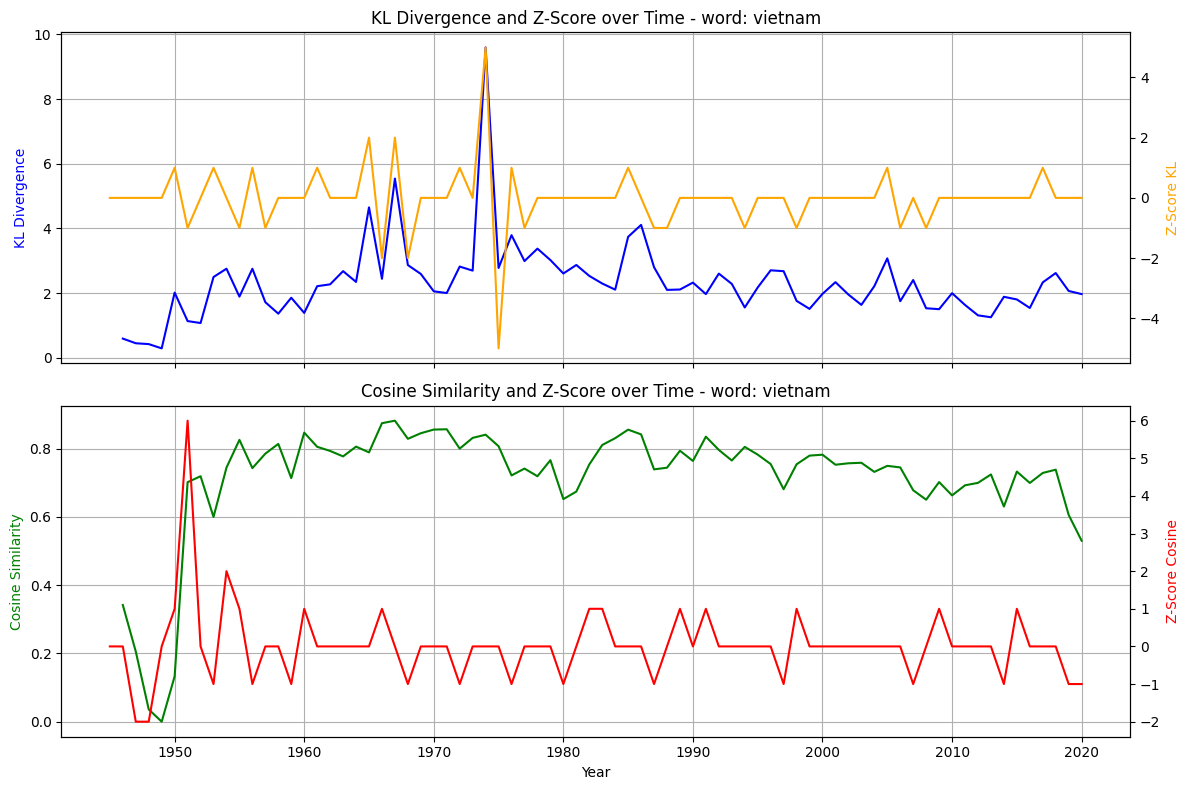

In [79]:
word = "vietnam"
plot_KL_vs_COS(df_chain, word=word)

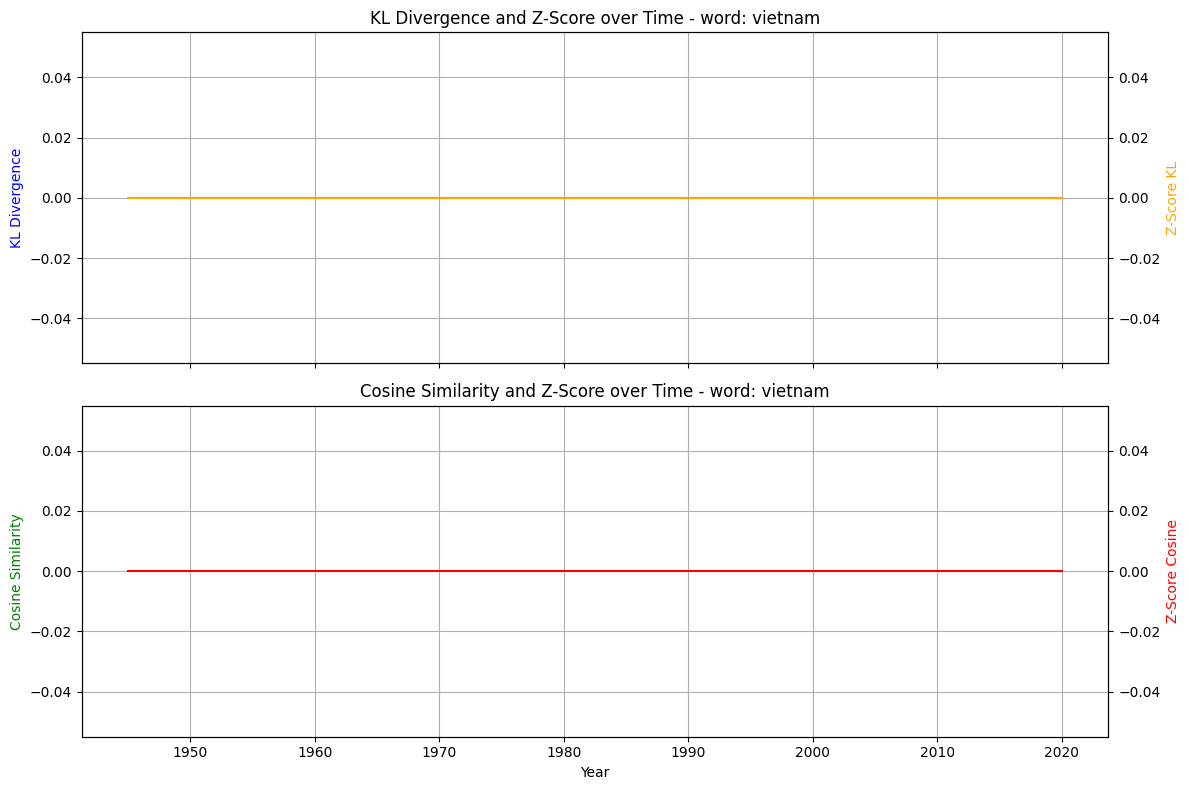

In [80]:
plot_KL_vs_COS(df_fixed, word=word)

## Sample Selection

In [118]:
word_counts = df_chain.groupby('word')['kl_divergence'].count()
words_with_enough_data = word_counts[word_counts > 70].index
sample_words = np.random.RandomState(46).choice(words_with_enough_data, size=1000, replace=False)

df_sample = df_chain[df_chain.word.isin(sample_words)]


## Hidden Markov Model - Training

In [ ]:
from hmmlearn.hmm import CategoricalHMM

def fit_categorical_hmm(sequence: pd.Series, n_states: int = 3, n_symbols: int = 13):
    sequence = sequence.dropna().astype(int)
    if len(sequence) < n_states * 2 or len(set(sequence)) < 2:
        return None
    try:
        model = CategoricalHMM(n_components=n_states, n_iter=100, random_state=42, verbose=True)
        model.n_features = n_symbols

        # Prepend missing symbols to ensure full observation exposure
        seq = list(set(range(n_symbols))) + list(sequence)
        seq = np.array(seq).reshape(-1, 1)

        model.fit(seq)
        return model
    except Exception as e:
        print(f"Error fitting HMM: {e}")
        return None

In [120]:
N_SYMBOLS = 5

models = {}
for word, group in df_sample.groupby('word'):
    try:
        seq = group.sort_values('year')['hmm_state']
        model = fit_categorical_hmm(seq, n_states=3, n_symbols=N_SYMBOLS)
        if model:
            models[word] = model
    except Exception as e:
        print(f"Failed to fit KL model for word '{word}': {e}")

models_cos = {}
for word, group in df_sample.groupby('word'):
    try:
        seq = group.sort_values('year')['hmm_state_cos']
        model = fit_categorical_hmm(seq, n_states=3, n_symbols=N_SYMBOLS)
        if model:
            models_cos[word] = model
    except Exception as e:
        print(f"Failed to fit COS model for word '{word}': {e}")




In [112]:
def hmm_to_vector(model):
    return np.concatenate([
        model.startprob_,
        model.transmat_.flatten(),
        model.emissionprob_.flatten()
    ])

## Visualization of model's features